# Embedding a neuron model in a network model

This tutorial guides the user through how to use ISF to embed a neuron model in a dense connectome model, creating synaptic connections. We provide a network modeling pipeline that has been described in detail in [Udvary et al. (2022)](https://doi.org/10.1016/j.celrep.2022.110677). 
The directory `anatomical constraints` in the example data section provides the empirical data needed for such anatomical model:
- Synapse locations on the dendrites and soma of the postsynaptic morphology of interest.
- Cell type specific soma locations
- Amount of presynaptic cells that are connected to the postynaptic morphology

These values do not all need to originate from the same animal, cell or morphology.

In [1]:
import Interface as I
from getting_started import getting_started_dir, tutorial_output_dir, example_data_dir
import os
db = I.DataBase(tutorial_output_dir)
example_data_dir = I.os.path.join(getting_started_dir, 'example_data')
db = db.create_sub_db("network_modeling")

[INFO] distributed_lock: trying to connect to distributed locking server {'config': {'hosts': 'somalogin02:33333'}, 'type': 'zookeeper'}
[INFO] distributed_lock: success!
[INFO] l5pt: Loading mechanisms:
[WARNING] somatic_summation_model: Deprecation warning: This module is deprecated and will be removed in a future release.


--No graphics will be displayed.


[INFO] ISF: Current version: heads/docs+0.gadcd56d2.dirty
[INFO] ISF: Current pid: 189089
[ATTENTION] ISF: The source folder has uncommited changes!
[WARNING] ISF: Could not load linked views



[INFO] ISF: Loaded modules with __version__ attribute are:
IPython: 8.12.2, Interface: heads/docs+0.gadcd56d2.dirty, PIL: 10.4.0, _brotli: 1.0.9, _csv: 1.0, _ctypes: 1.1.0, _curses: b'2.2', _decimal: 1.70, argparse: 1.1, backcall: 0.2.0, blosc: 1.11.1, bluepyopt: 1.9.126, brotli: 1.0.9, certifi: 2024.08.30, cffi: 1.17.0, charset_normalizer: 3.4.0, click: 7.1.2, cloudpickle: 3.1.0, colorama: 0.4.6, comm: 0.2.2, csv: 1.0, ctypes: 1.1.0, cycler: 0.12.1, cytoolz: 0.12.3, dash: 2.18.2, dask: 2.30.0, dateutil: 2.9.0, deap: 1.4, debugpy: 1.8.5, decimal: 1.70, decorator: 5.1.1, defusedxml: 0.7.1, distributed: 2.30.0, distutils: 3.8.20, django: 1.8.19, entrypoints: 0.4, executing: 2.1.0, fasteners: 0.17.3, flask: 1.1.4, fsspec: 2024.10.0, future: 1.0.0, greenlet: 3.1.1, idna: 3.10, ipaddress: 1.0, ipyke

## Step 1: Register the cell morphology in the desired reference frame

The first step to embedding a neuron model into a network model, is to align the reference frames of both.

From external resources (e.g. the NeuroMorph pipeline), you need a morphology `.hoc`-file. The coordinates in the hoc morphology file need to be anchored at the desired location.

As an example, we already provide such file of a Layer-5 Pyramidal Tract Neuron (L5PT) whose coordinates are anchored in the C2 column of a rat barrel cortex (BC)

In [2]:
I.os.listdir(
    I.os.path.join(
        getting_started_dir, 
        'example_data', 
        'anatomical_constraints'))

['86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center_synapses_20150504-1611_10389',
 '89_L5_CDK20050712_nr6L5B_dend_PC_neuron_transform_registered_C2.hoc',
 '86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center.hoc',
 '86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center.swc',
 '86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center_scaled_diameters.hoc']

For building the anatomical model, we use `86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center.hoc`, for the simulation of the evoked activity, we need to use the morphology file with scaled apical trunk.

In [3]:
path_to_hoc = I.os.path.join(
    getting_started_dir, 
    'example_data', 
    'anatomical_constraints',
    '86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center.hoc')
path_to_scaled_hoc = I.os.path.join(
    getting_started_dir, 
    'example_data', 
    'anatomical_constraints', \
    '86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center_scaled_diameters.hoc')

We copy these files to our DataBase. 

In [4]:
if not 'anatomical_constraints' in db.keys():
    db.create_managed_folder('anatomical_constraints')
    I.shutil.copy(path_to_hoc, db['anatomical_constraints'])
    I.shutil.copy(path_to_scaled_hoc, db['anatomical_constraints'])

## Step 2: calculate positions of anatomical synapses with respect to the registered morphology

We use [`singlecell_input_mapper`](../singlecell_input_mapper/readme.md) to create an anatomical model of how that cell is integrated in the brain are (here: the barrel cortex). For more information on how this is done, see [Egger et al. 2014](https://www.frontiersin.org/articles/10.3389/fnana.2014.00129/full). This module creates an anatomical reconstruction of axo-dendritic connections depending on the spatial distribution of cells, bouton density, and anatomical constraints of post-synaptic targets of the postsynaptic cell, such as morphology and synapse density. To do so, it needs the following input:
1. The neuron morphology (the `.hoc` file that we already copied over)
2. Density of total Post-Synaptic Target sites (PST) across the dendritic tree of the postynaptic cell (used for normalization)
3. Anatomical constraints of PSTs: the amount of synapses per length unit and area unit, depending on pre- and post-synaptic celltype, and the location along the dendritic tree of the postsynaptic cell. These are normalized using the previously mentioned PST densities.
4. Bouton densities across the entire brain area of interest.
5. Spatial distribution of cells, depending on their type.

Under the hood, 50 anatomical realizations will be computed that are congruent with the input criteria. From this distribution of anatomical realizations, the one that is closest to the average is chosen, which can be refered to as a "representative realization". The result is saved in the same folder as the hoc morphology. This takes about 4 hrs to compute, but you can continue with a precomputed result.

To compute it yourself, run the cell below. To copy a precomputed result, you can skip to the next code cell

In [ ]:
# Computing it yourself (this takes some time): --------------------
celltype = 'L5tt'  # Layer 5 thick-tufted, aka L5PT (pyramidal tract), aka L5ET (extratelencephalic)
path = db['anatomical_constraints'].join(
    '86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center.hoc')
with I.silence_stdout:  # Silence output
    I.map_singlecell_inputs(
        cellName=path, 
        cellTypeName=celltype)

# adapt the path, if you have generated a new anatomical model
path_to_anatomical_model = db['anatomical_constraints'].join(
    '86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center_synapses_20150504-1611_10389')

In [5]:
# Pre-computed result: --------------------
from distutils.dir_util import copy_tree
dirname = '86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center_synapses_20150504-1611_10389'
path_to_anatomical_model = I.os.path.join(getting_started_dir, 'example_data', 'anatomical_constraints', dirname, dirname)
silent = copy_tree(path_to_anatomical_model, db['anatomical_constraints'])

### How to parallelize the generation of anatomical models?

We can use a distributed [`distributed.Client`](https://distributed.dask.org/en/latest/client.html) to create our `.syn` and `.con` files for one morphology per process:

In [6]:
client = I.get_client(timeout=10)

In [7]:
import psutil
print(psutil.cpu_count(logical=True))

40


In [8]:
morphology_paths = [db['anatomical_constraints'].join(f) for f in db['anatomical_constraints'].listdir() if f.endswith('.hoc')]
morphology_paths

['/gpfs/soma_fs/home/meulemeester/ISF_tutorial_output/network_modeling/db/anatomical_constraints/86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center.hoc',
 '/gpfs/soma_fs/home/meulemeester/ISF_tutorial_output/network_modeling/db/anatomical_constraints/86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center_scaled_diameters.hoc']

This takes as long as creating an anatomical realization for a single cell, but thanks to parallellization, not much longer than that. At least, until the amount of cells exceed the amount of available threads.

In [ ]:
delayed_map_singlecell_inputs = I.dask.delayed(I.map_singlecell_inputs)  # make the single cell mapper a delayed function
delayeds = [delayed_map_singlecell_inputs(p, 'L5tt') for p in morphology_paths] # call it with the morphologies
delayeds = I.dask.delayed(delayeds) # bundle everything in one delayed object
futures = client.compute(delayeds)  # compute the result

You can restart the client to interrupt this computation if don't want to compute this right now

In [135]:
client.restart()

Client Scheduler: tcp://10.100.2.202:38786 Dashboard: http://10.100.2.202:38787/status,Cluster Workers: 40 Cores: 40 Memory: 4.00 TB


## Inspecting the network model

Let's start by visualizing the locations of the somata to get a sense of our network model.

In [9]:
landmarks = []
cell_types = []

somata = I.pd.read_csv(
    db["anatomical_constraints"].join("presynaptic_somata/presynaptic_somata_soma_locations.csv"), 
    skiprows=[0,1,2,3],
    header=None,
    delimiter="\t",
    names=['Type', 'cell ID', 'x', 'y', 'z']
    )
somata[['cell_type', 'column']] = somata['Type'].str.split('_', n=1, expand=True)
somata

,Type,cell ID,x,y,z,cell_type,column
0,L45Peak_D1,0,-626.213,20.344,-58.270,L45Peak,D1
1,L45Peak_D1,1,-320.834,13.905,-248.013,L45Peak,D1
2,L45Peak_D1,2,-471.762,100.233,-114.434,L45Peak,D1
3,L45Peak_D1,3,-423.770,94.010,-156.002,L45Peak,D1
4,L45Peak_D1,4,-294.765,145.499,-241.157,L45Peak,D1
...,...,...,...,...,...,...,...
19699,L34_D3,292,485.718,83.024,122.828,L34,D3
19700,L34_D3,293,483.525,-213.608,190.240,L34,D3
19701,L34_D3,294,586.649,-160.437,98.395,L34,D3
19702,L34_D3,295,275.697,189.550,319.151,L34,D3


In [10]:
%matplotlib inline
I.plt.style.use('ggplot')

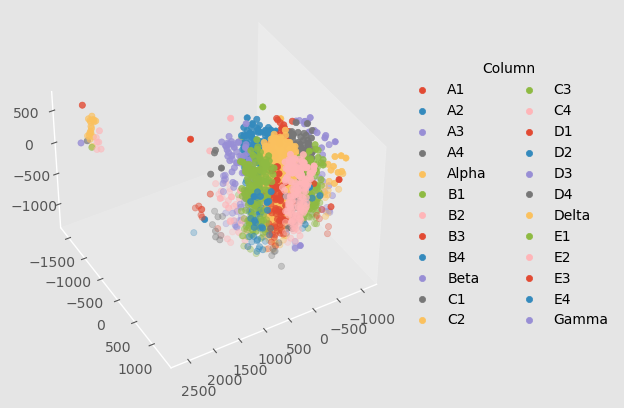

In [11]:
fig = I.plt.figure()
ax = fig.add_subplot(projection='3d')
fig.patch.set_facecolor(ax.get_facecolor())
ax.view_init(azim=60, elev=40)
ax.grid(False)

for column, pts in somata.sample(2000).groupby("column"):
    x, y, z = pts[["x", "y", "z"]].values.T
    ax.scatter(
        x, y, z, 
        label=column)

ax.legend(
    bbox_to_anchor=(1, 0.5), 
    loc='center left', 
    frameon=False, 
    ncol=2,
    title="Column")
I.plt.show()

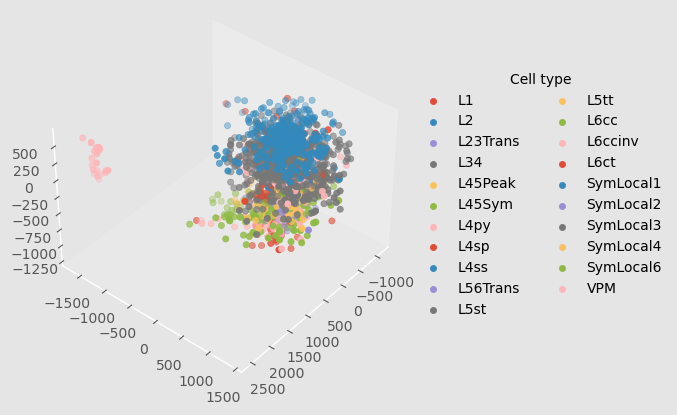

In [12]:
fig = I.plt.figure()
ax = fig.add_subplot(projection='3d')
fig.patch.set_facecolor(ax.get_facecolor())
ax.view_init(azim=40, elev=40)
ax.grid(False)

for cell_type, pts in somata.sample(2000).groupby("cell_type"):
    x, y, z = pts[["x", "y", "z"]].values.T
    ax.scatter(
        x, y, z,
        label=cell_type)

ax.legend(
    bbox_to_anchor=(1, 0.5), 
    loc='center left', 
    frameon=False, 
    ncol=2,
    title="Cell type")
I.plt.show()

In the directory generated by the singlecell_input_mapper, there are the following files:

In [13]:
db['anatomical_constraints'].listdir()

['Loader.json',
 '86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center_synapses_20150504-1611_10389.syn',
 '86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center_summary_20150504-1611_10389.csv',
 'total_synapses',
 '86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center.hoc',
 'presynaptic_somata',
 'NumberOfConnectedCells.csv',
 'apical_synapses',
 '86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center_synapses_20150504-1611_10389.con',
 '86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center_scaled_diameters.hoc',
 '86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center_scaled_diameters_synapses_20241218-1447_61383',
 '86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center_synapses_20241218-1447_61400',
 'metadata.json',
 'soma_synapses',
 'basal_synapses']

The most important files for making single-cell simulations are the `.con` file and the `.syn` file. These files are the relevant output of the `SingleCellMapper` for simulations of evoked activity.

The `.con` file maps presynaptic cells to a synapse. Not just a celltype, but all individual cells with a specific `cell ID` are mapped to an individual synapse with `synase ID`.

In [14]:
con_file = db['anatomical_constraints'].get_file('.con')
con_file_path = db['anatomical_constraints'].join(con_file)
con_file_path

'/gpfs/soma_fs/home/meulemeester/ISF_tutorial_output/network_modeling/db/anatomical_constraints/86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center_synapses_20150504-1611_10389.con'

In [15]:
with open(con_file_path) as f:
    print(f.read()[:300])

# Anatomical connectivity realization file; only valid with synapse realization:
# 86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center_synapses_20150504-1611_10389.syn
# Type - cell ID - synapse ID

L6cc_A3	0	0
L6cc_A3	1	1
L6cc_A3	2	2
L6cc_A3	3	3
L6cc_A3	4	4
L6cc_A3	4	5
L6cc_A3	5	6


The `.syn` file specifies the exact position of each synapse on the hoc morphology:

In [16]:
syn_file_path = db['anatomical_constraints'].join(db['anatomical_constraints'].get_file('.syn'))
with open(syn_file_path) as f:
    print(f.read()[:300])

# Synapse distribution file
# corresponding to cell: 86_L5_86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center
# Type - section - section.x

VPM_E1	112	0.138046479525
VPM_E1	130	0.305058053119
VPM_E1	130	0.190509288017
VPM_E1	9	0.368760777084
VPM_E1	110	0.0
VPM_E1	11	0.120662910562


Here, section referes to the ID of the section in the cell object. x specifies, where along that section the synapse is placed. If x is 0, this is the beginning of the section, if x is one, this is the end of the section.

This setup now covered all the necessary conditions to run a simulations where individual synapses are activated and evoke PSPs onto a taret neuron. See [the next notebook](./2.2%20Network%20activity.ipynb) on how to generate synaptic activations for these synapses.